In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
import random

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
data_gen =  ImageDataGenerator(rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    rescale= 1./255,
    horizontal_flip=True,
    fill_mode='nearest') #here the decimals are the maximum change percentage for each parameter. 
#rescale-->multplying the pixels by given number --> Normlisation.

In [6]:
data_gen.flow_from_directory("Natural Images Dataset/seg_train/seg_train") #this is how we gonna import the data to put into model training

Found 14034 images belonging to 6 classes.


In [7]:
input_shaped = [150,150,3] #since the VGG16 model weights were achived on this input_shape on image
vgg16 = VGG16(input_shape = input_shaped,weights='imagenet',include_top = False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
#we wont train the existing weights.
for layer in vgg16.layers:
    layer.trainable = False

In [9]:
x = Flatten()(vgg16.output) #we can add more layers if we want to our fully connected network
prediction = Dense(6,activation = 'softmax')(x) #we have got 131 classes to predict
model = Model(inputs = vgg16.input,outputs = prediction)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [11]:
model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [15]:
batch_sized = 32

train_image_gen = data_gen.flow_from_directory('Natural Images Dataset/seg_train/seg_train',
                                                batch_size = batch_sized,target_size = (150,150),
                                              class_mode='categorical')

Found 14034 images belonging to 6 classes.


In [16]:
batch_sized = 32

test_image_gen = data_gen.flow_from_directory('Natural Images Dataset/seg_test/seg_test',
                                                batch_size = batch_sized,target_size = (150,150),
                                              class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [17]:
print(train_image_gen.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [18]:
r = model.fit_generator(
              train_image_gen,
              validation_data=test_image_gen,
              epochs=10,
              steps_per_epoch=len(train_image_gen),
              validation_steps=len(test_image_gen))

Epoch 1/10
439/439 [==============================] - 1854s 4s/step - loss: 0.5559 - acc: 0.7949 - val_loss: 0.4397 - val_acc: 0.8327
Epoch 2/10
439/439 [==============================] - 1951s 4s/step - loss: 0.4341 - acc: 0.8424 - val_loss: 0.4207 - val_acc: 0.8467
Epoch 3/10
439/439 [==============================] - 2116s 5s/step - loss: 0.4214 - acc: 0.8502 - val_loss: 0.4442 - val_acc: 0.8470
Epoch 4/10
439/439 [==============================] - 1886s 4s/step - loss: 0.3953 - acc: 0.8571 - val_loss: 0.4180 - val_acc: 0.8457
Epoch 5/10
439/439 [==============================] - 2033s 5s/step - loss: 0.3924 - acc: 0.8559 - val_loss: 0.4079 - val_acc: 0.8560
Epoch 6/10
439/439 [==============================] - 1971s 4s/step - loss: 0.3718 - acc: 0.8645 - val_loss: 0.4522 - val_acc: 0.8470
Epoch 7/10
439/439 [==============================] - 1977s 5s/step - loss: 0.3822 - acc: 0.8617 - val_loss: 0.4758 - val_acc: 0.8300
Epoch 8/10
260/439 [================>.............] - ETA: 11:

KeyboardInterrupt: 

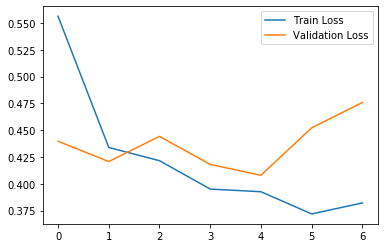

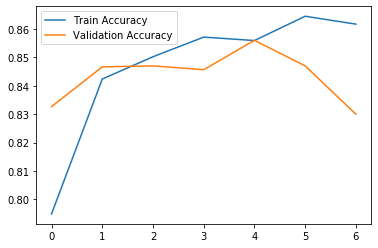

In [19]:

plt.plot(model.history.history['loss'],label = 'Train Loss')
plt.plot(model.history.history['val_loss'],label = 'Validation Loss')
plt.legend()
plt.show()

plt.plot(model.history.history['acc'],label = 'Train Accuracy')
plt.plot(model.history.history['val_acc'],label = 'Validation Accuracy')
plt.legend()
plt.show()

In [20]:
from tensorflow.keras.models import load_model

model.save('vgg16_nature_classifier1.h5') #model saving

In [21]:
model=load_model('vgg16_nature_classifier1.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [23]:
from tensorflow.keras.preprocessing import image
img = image.load_img('buildings.jpeg',target_size = (150,150))

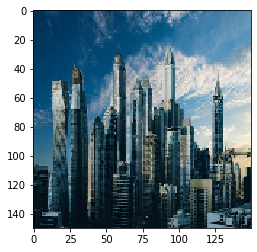

In [24]:
plt.imshow(img)

In [25]:
img = image.img_to_array(img)
img = img/255
test_img = np.expand_dims(img,axis=0)
prediction = model.predict(test_img)

In [26]:
final_pred = np.argmax(prediction,axis=1)

In [27]:
final_pred

array([0], dtype=int64)

In [28]:
#prediction made correct!

In [29]:
from tensorflow.keras.preprocessing import image
img = image.load_img('street.jpg',target_size = (150,150))

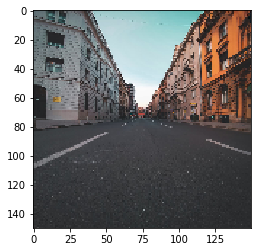

In [30]:
plt.imshow(img)

In [31]:
img = image.img_to_array(img)
img = img/255
test_img = np.expand_dims(img,axis=0)
prediction = model.predict(test_img)

In [36]:
final_pred = np.argmax(prediction,axis=1)[0]

In [37]:
final_pred

5

In [34]:
#boom!! ready for deployment!!!